In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import spearmanr
import tifffile as tf
from false_positive_analysis import percent_false_positive
%config InlineBackend.figure_format='retina'

# Look at false positive rate

In [58]:
#read in threshold mtx
#do you want to look at deepcell dots or daostar
deepcell = True
seed = 4

if deepcell == False:
    thresh_mtx = []
    for i in range(11):
        ch_mtx = pd.read_csv(f"/groups/CaiLab/personal/Lex/raw/020422_20kdash_3t3/notebook_pyfiles/genebycell/daostar/seed_{seed}/Threshold_{i}/genebycell.csv", index_col=0)
        thresh_mtx.append(ch_mtx)

else:
    mtx = pd.read_csv(f"/groups/CaiLab/personal/Lex/raw/020422_20kdash_3t3/notebook_pyfiles/genebycell/deepcell/seed_{seed}/genebycell.csv", index_col=0)

In [59]:
#read in rnaseq data
rnaseq_1 = pd.read_csv("nih3t3_FPKM.csv")
rnaseq_2 = pd.read_csv("kallisto_NIH3T3.csv")
#rnaseq= rnaseq[["tracking_id","E14J B1"]]
rnaseq_1.columns = ["Genes","FPKM"]

In [60]:
#codebook
codebook = pd.read_csv("/groups/CaiLab/personal/Lex/raw/112221_20kdash_3t3/barcode_key/corrected_codebook.csv")
codebook.columns = ["Gene", "Brcd1", "Brcd2"]

In [61]:
#separate into true and false codebook
fakebook = codebook[codebook["Gene"].str.startswith("fake")]
codebook = codebook.drop(fakebook.index)

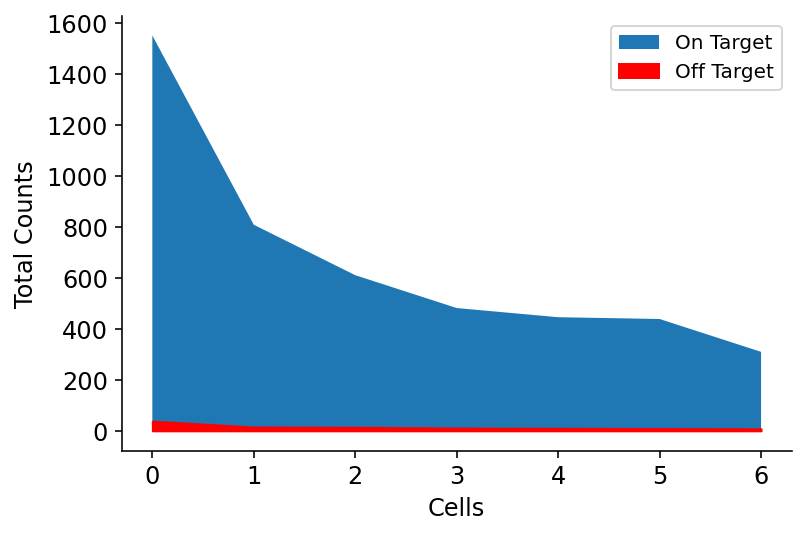

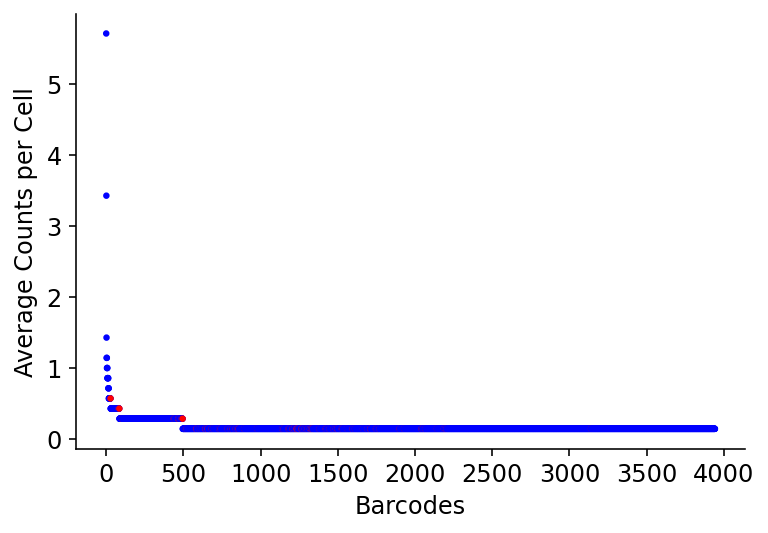

,percent fp,false positive rate,mean counts,total sum
0,0.023299,1.00292,664.142857,4649.0


In [62]:
#calculate false positive
if deepcell == False:
    fp_list = []
    for i in range(11):
        fp, fake, norm_fpr= percent_false_positive(thresh_mtx[i], codebook, fakebook)
        percent_fp = fp["FP raw"].mean()
        mean_counts = fp["total_counts"].mean()
        sum_counts = fp["total_counts"].sum()
        fp_list.append([percent_fp,norm_fpr,mean_counts,sum_counts])
else:
    fp_list = []
    fp, fake, norm_fpr= percent_false_positive(mtx, codebook, fakebook)
    percent_fp = fp["FP raw"].mean()
    mean_counts = fp["total_counts"].mean()
    sum_counts = fp["total_counts"].sum()
    fp_list.append([percent_fp,norm_fpr,mean_counts,sum_counts])

#conver to df
df_stats = pd.DataFrame(fp_list)
df_stats.columns = ["percent fp","false positive rate","mean counts", "total sum"]
df_stats

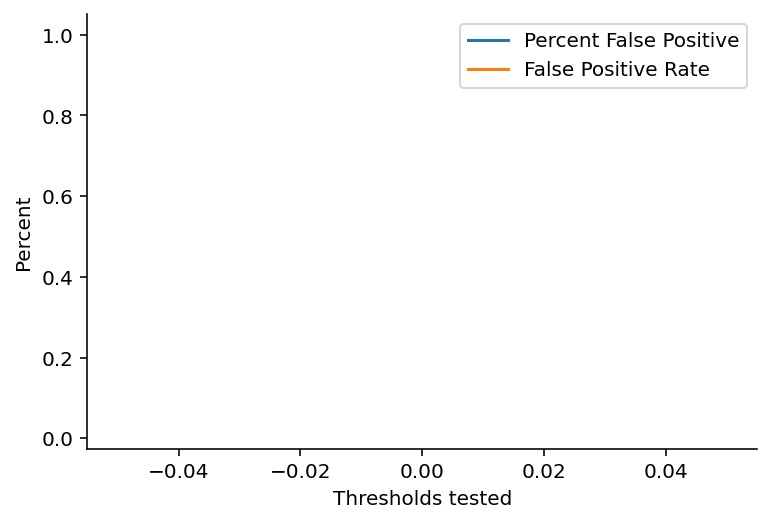

In [63]:
#plot fpr and percent falsepsotive
plt.plot(df_stats["percent fp"], label = "Percent False Positive")
plt.plot(df_stats["false positive rate"], label = "False Positive Rate")
plt.ylabel("Percent")
plt.xlabel("Thresholds tested")
sns.despine()
plt.legend()

No handles with labels found to put in legend.


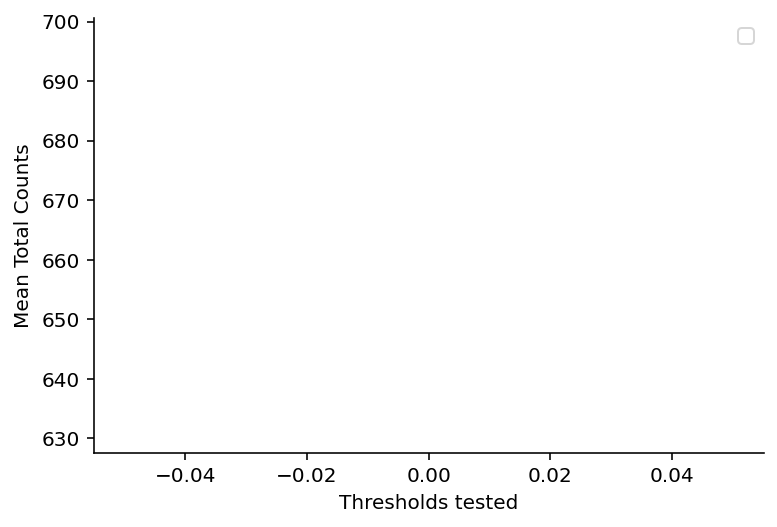

In [64]:
#plot average counts
plt.plot(df_stats["mean counts"])
plt.ylabel("Mean Total Counts")
plt.xlabel("Thresholds tested")
sns.despine()
plt.legend()

# Look at percent decoded dots

In [65]:
def keep_dots_in_cells(mask, dot_locations):
    """
    A function to remove any dots outside of mask
    Parameter
    ---------
    mask = cellpose generated mask path
    dot_locations = dot_locations path
    """
    
    #read in data
    locations = pd.read_csv(dot_locations)
    #cellpose mask outputs (c,y,x)
    img = tf.imread(mask)
    #get x and y coordinates
    locations_xy = locations[["x","y"]].values.astype(int)
    dot_info = []
    #keep dots only in cells
    for i in range(len(locations)):
        x = locations_xy[i][0]
        y = locations_xy[i][1]
        if img[y,x] == 0:
            continue
        else:
            cell = img[y,x]
            dot_info.append([i,cell])
            
    dot_info = np.array(dot_info)
    
    #keep rows that have cells
    dots_in_cells = locations.loc[dot_info[:,0]]
    
    #add cell info
    dots_in_cells["cell number"] = dot_info[:,1]
    
    return dots_in_cells

In [66]:
#look at total counts and keep only ones in masks

if deepcell == False:
    dot_list = []
    for i in range(11):
        mask = "/groups/CaiLab/personal/Lex/raw/020422_20kdash_3t3/notebook_pyfiles/edges_deleted/MMStack_Pos0.ome.tif"
        dot_locations = f"/groups/CaiLab/personal/Lex/raw/020422_20kdash_3t3/notebook_pyfiles/dots_comb/channels_combined/Threshold_{i}/locations_z_0.csv"
        dots = keep_dots_in_cells(mask, dot_locations)
        dot_list.append(dots)
else:
    mask = "/groups/CaiLab/personal/Lex/raw/020422_20kdash_3t3/notebook_pyfiles/edges_deleted/MMStack_Pos0.ome.tif"
    dot_locations = "/groups/CaiLab/personal/Lex/raw/020422_20kdash_3t3/notebook_pyfiles/dots_detected/Pos0/locations_z_0.csv"
    dots = keep_dots_in_cells(mask, dot_locations)
    dots = dots[dots["hyb"] != 12]

In [67]:
#divide total counts by 4 barcoding rounds to get rough estimate on dots per barcode round
if deepcell == False:
    total_dots = []
    for _ in range(11):
        total_dots.append((len(dot_list[_])/4))
else:
    total_dots = len(dots)/4

total_dots

103706.25

[0.04482854]


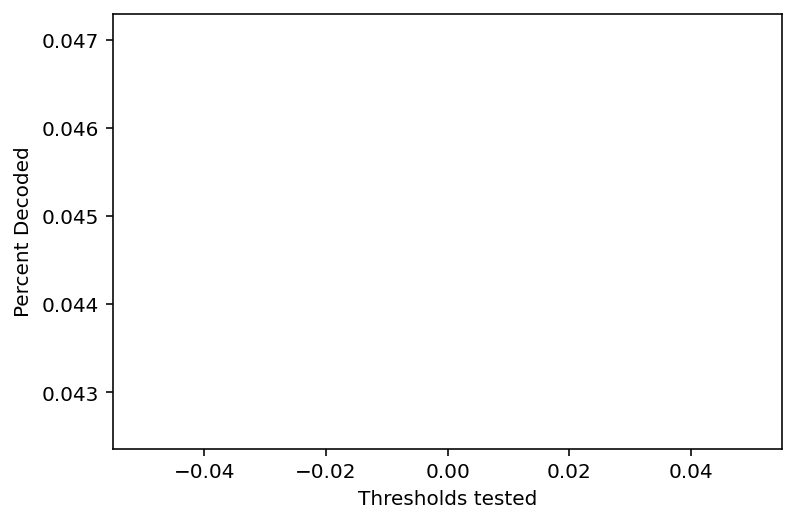

In [68]:
#percent decoded plots
plt.plot(df_stats["total sum"].values / np.array(total_dots))
plt.ylabel("Percent Decoded")
plt.xlabel("Thresholds tested")
print(df_stats["total sum"].values / np.array(total_dots))

# RNA seq correlations

In [ ]:
# fp, fake, norm_fpr= percent_false_positive(thresh_mtx[0], codebook, fakebook)
fp, fake, norm_fpr= percent_false_positive(mtx, codebook, fakebook)

In [ ]:
#convert data to pseudobulk rnaseq data
if deepcell == False:
    bulk = pd.DataFrame(thresh_mtx[3].mean(axis=1)).reset_index()
    bulk.columns = ["Genes", "Counts"]
else:
    bulk = pd.DataFrame(mtx.mean(axis=1)).reset_index()
    bulk.columns = ["Genes", "Counts"]

In [ ]:
#rename rnaseq columns and lowercase
rnaseq_2.columns = ["Genes", "TPM"]
rnaseq_1["Genes"]=rnaseq_1["Genes"].str.lower()
rnaseq_2["Genes"]=rnaseq_2["Genes"].str.lower()

In [ ]:
#merge
comb_1 = pd.merge(rnaseq_1,bulk)
comb_2 = pd.merge(rnaseq_2,bulk)

In [ ]:
#sort
sort_comb_1 = comb_1.sort_values(["FPKM"])
sort_comb_2 = comb_2.sort_values(["TPM"])

In [ ]:
#pearson calc old rnaseq
linreg = linregress(x = sort_comb_1["FPKM"], y = sort_comb_1["Counts"])
pearsonr = linreg[2]
pearsonr = round(pearsonr,2)
pearsonr

In [ ]:
#pearson calc new rnaseq
linreg = linregress(x = sort_comb_2["TPM"], y = sort_comb_2["Counts"])
pearsonr = linreg[2]
pearsonr = round(pearsonr,2)
pearsonr

In [ ]:
#plot correlation
plt.scatter(np.log10(sort_comb_2["Counts"]),np.log10(sort_comb_2["TPM"]), s = 5, alpha=0.5)
plt.ylabel("Bulk RNAseq Log10(FPKM)", fontsize=12)
plt.xlabel("Pseudobulk Log10(Counts)", fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.annotate(f"Pearson's r= {pearsonr}", (-1.5,1.5), fontsize=12)
sns.despine()